<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/module_P6_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner --upgrade --quiet


You should consider upgrading via the '/home/vincent/devel/vjuge/oc-iml/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageShow
import cv2 as cv
import sklearn

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import layers
import keras_tuner as kt


from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


2022-07-06 09:33:40.312639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 09:33:40.312666: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

GPU device not found


2022-07-06 09:33:43.871733: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 09:33:43.874122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vincent/devel/vjuge/oc-iml/venv/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-06 09:33:43.874142: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 09:33:43.874163: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rocketstation): /proc/driver/nvidia/version does not exist


## Download Dataset

In [4]:
# tfds.disable_progress_bar()

(train_ds, test_ds), ds_info = tfds.load(
    "stanford_dogs",
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

In [5]:
NO_BREEDS = ds_info.features['label'].num_classes

In [6]:
ds_info.features['label']
ds_info.features['label'].names[:20]

ClassLabel(shape=(), dtype=tf.int64, num_classes=120)

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound']

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## Dataset preprocessing

1. On applique un resizing des images afin d'avoir un dataset consistant.

> note: on peut resizer à 150 x 150, car si on garde 299 x 299 (default XCeption), la ram est tout juste suffisante sur collab, le fitting peut planter :

```
Votre session a planté après avoir utilisé toute la RAM disponible.

En tant qu'abonné Colab Pro, vous disposez de plus de mémoire, mais si vous êtes intéressé par des environnements d'exécution à mémoire RAM encore plus élevée, envisagez de passer à Colab Pro+.
```


2. On applique aussi un One Hot sur les labels

In [8]:
IMG_SIZE = 299
size = (IMG_SIZE, IMG_SIZE)


In [9]:
print(train_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [10]:
train_ds = train_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS))) # transform labels to one hot encoding

test_ds = test_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS))) #depth is number of classes


On applique un batching et un prefetch sur les datasets, cela va permettre de préparer et optimiser les dataset en vue de faire le fitting

In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

On applique une étape de data augmentation au dataset.
En effet, on ne dispose pas de beaucoup de samples, en appliquant des transformations aléatoires on augmente le nombre de samples.

On choisi d'appliquer deux transformations:
* mirroir horizontal (inverse la droite et la gauche)
* rotation (10% à droite ou à gauche)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

Exemple d'image du dataset après data augmentation :

<Figure size 720x720 with 0 Axes>

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

2022-07-06 09:33:45.178750: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


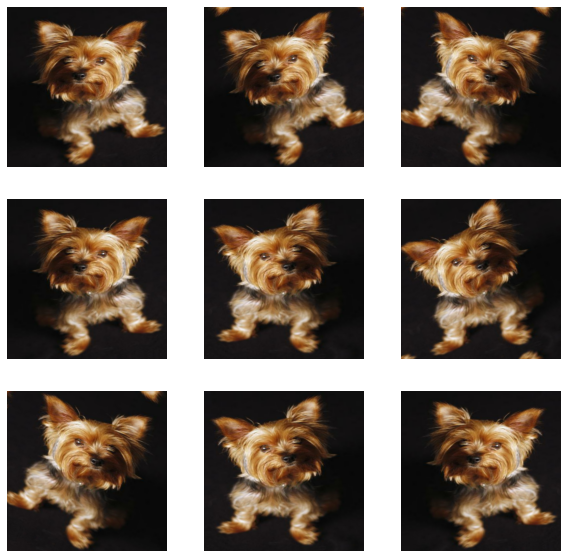

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        # plt.title(int(labels[0]))
        plt.axis("off")

In [14]:
# Function to display loss and accuracy graphs

def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

## Models Creation

On va créer des modèles simples, non pre-entrainé

### Fonctions Utilitaires

In [15]:
# on modifie dynamiquement le earning rate pour le diminuer au fur et à mesure des epochs
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

def compile_and_run(model, model_name: str, epochs = 20, save_model=False):
  model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
  )

  plot_model(model, show_shapes=True, show_layer_names=True, to_file=f'{model_name}.png')
  model.summary()

  callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8), # on limite le nombre d'epochs, si le loss arrette de baisser
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ProgbarLogger(count_mode="samples"),
    tf.keras.callbacks.LearningRateScheduler(scheduler) 
  ]

  history = model.fit(train_ds, epochs=epochs, validation_data=test_ds, callbacks=callbacks)
  plot_history_scores(history, "loss", "categorical_accuracy")
  if (save_model):
    model.save(f'{model_name}.h5')
  return history

### Modèle à une couche de convolution

In [ ]:
cnn1 = Sequential()
cnn1.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
cnn1.add(layers.Rescaling(1./255))
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
# cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(NO_BREEDS, activation='softmax'))

cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 flatten_2 (Flatten)         (None, 700928)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               89718912  
                                                      

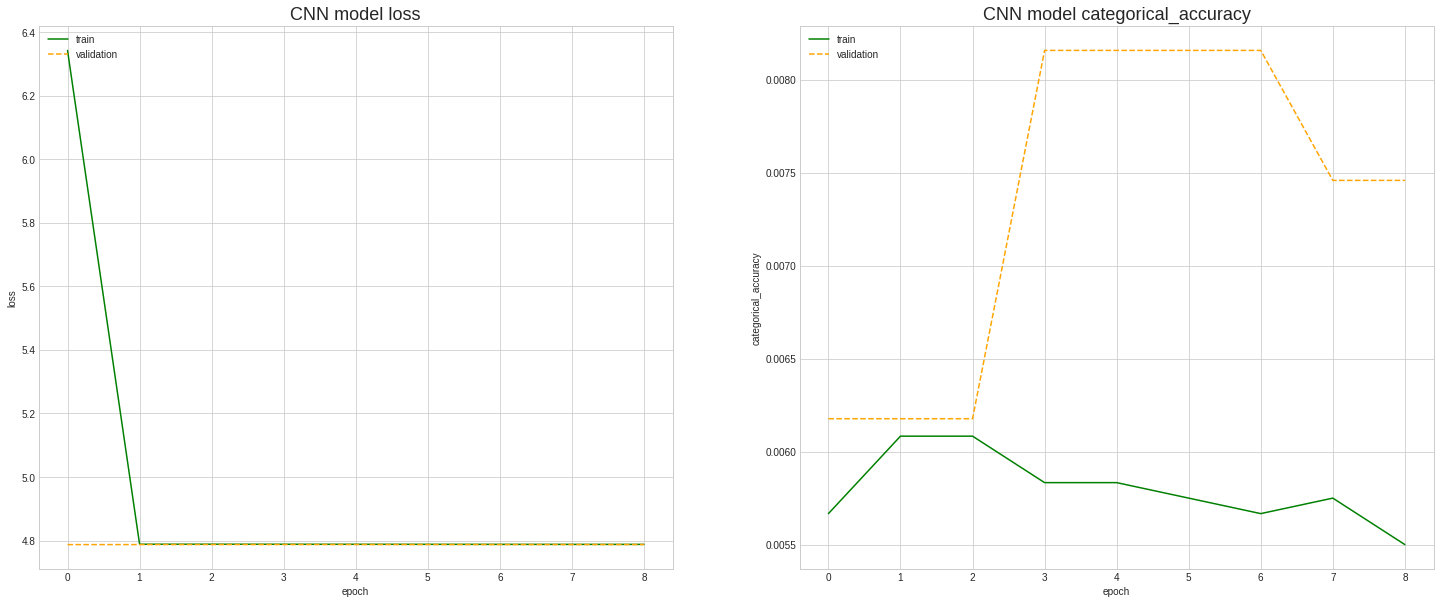

In [ ]:
compile_and_run(cnn1, "cnn1", 100)

Ce modèle est très mauvais, son accuracy est très faible. 

Par ailleurs, très rapidement il ne progresse plus et l'apprentissage s'arrette.

### Modèle à 3 couches de convolution

In [ ]:
cnn3 = Sequential()
cnn3.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
cnn3.add(layers.Rescaling(1./255))
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D((2, 2)))
# cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
# cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
# cnn3.add(Dropout(0.3))
cnn3.add(Dense(NO_BREEDS, activation='softmax'))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 148, 148, 32)     0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                  

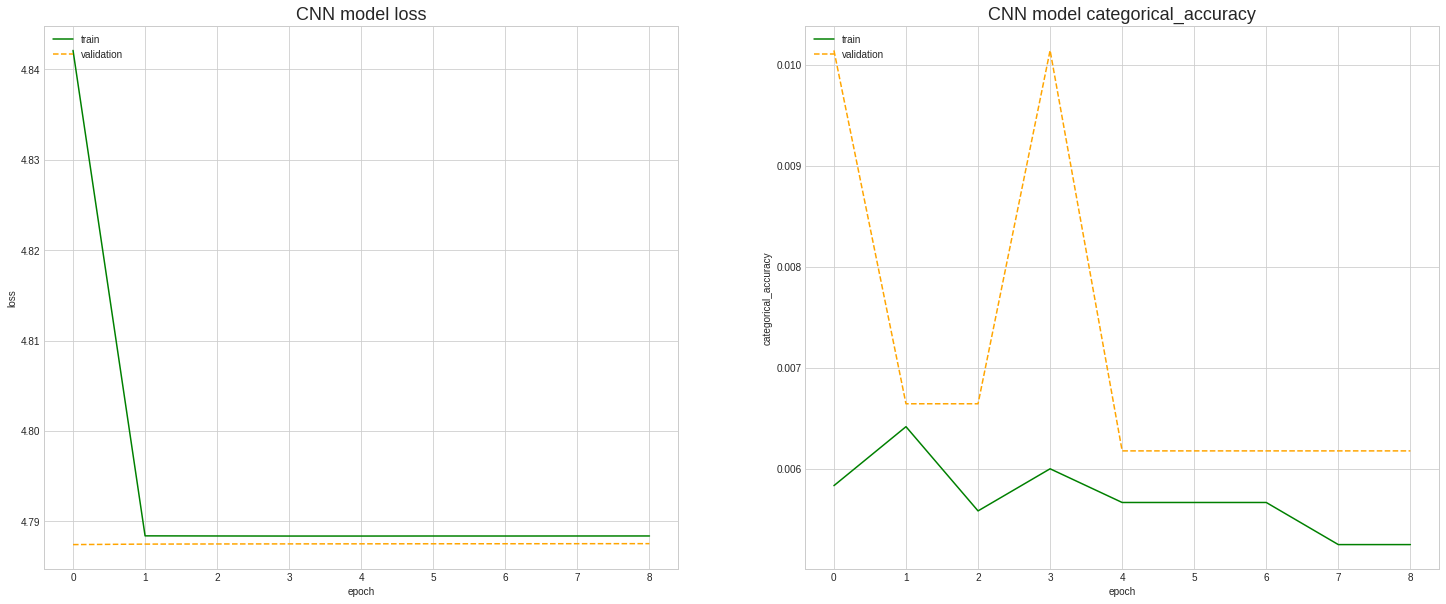

In [ ]:
compile_and_run(cnn3, "cnn3", 100)

Ce modèle n'est pas vraiment meilleur, l'apprentissage ne progresse plus dès l'epoch 9

### Optimisation du modèle à 3 couches

On va ajouter quelques éléments pour tenter d'améliorer les performances du modèle:

* ajout de DropOut : permet d'ajouter du 'bruit' et d'éviter l'over fitting
* modification des filtres de convolution
* ajout de normalisation en sortie des couches de convolution : permet de s'assurer de la distribution des valeurs en sortie de couche et de ce fait augmente la performance
* ajout d'une fonction d'activation en sortie des couches cachées
* suppression de la couche de flattening


sources:

batch normalization: <https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/>

activation functions choice: <https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/>

In [ ]:
model_scratch = Sequential([
  layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(filters=16,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.Activation('relu'),

  # Pooling layer
  layers.MaxPooling2D(pool_size=(4,4),
                      strides=(4,4),
                    padding='same'),
  layers.Dropout(0.2),

  # Second convolution layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.Activation('relu'), #new
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Third convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.GlobalAveragePooling2D(),
  
  # Fully connected layers
  layers.Dense(128, activation='relu'),
  layers.Dense(NO_BREEDS, activation='softmax')
])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 299, 299, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 299, 299, 16)     48        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 299, 299, 16)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 75, 32)       

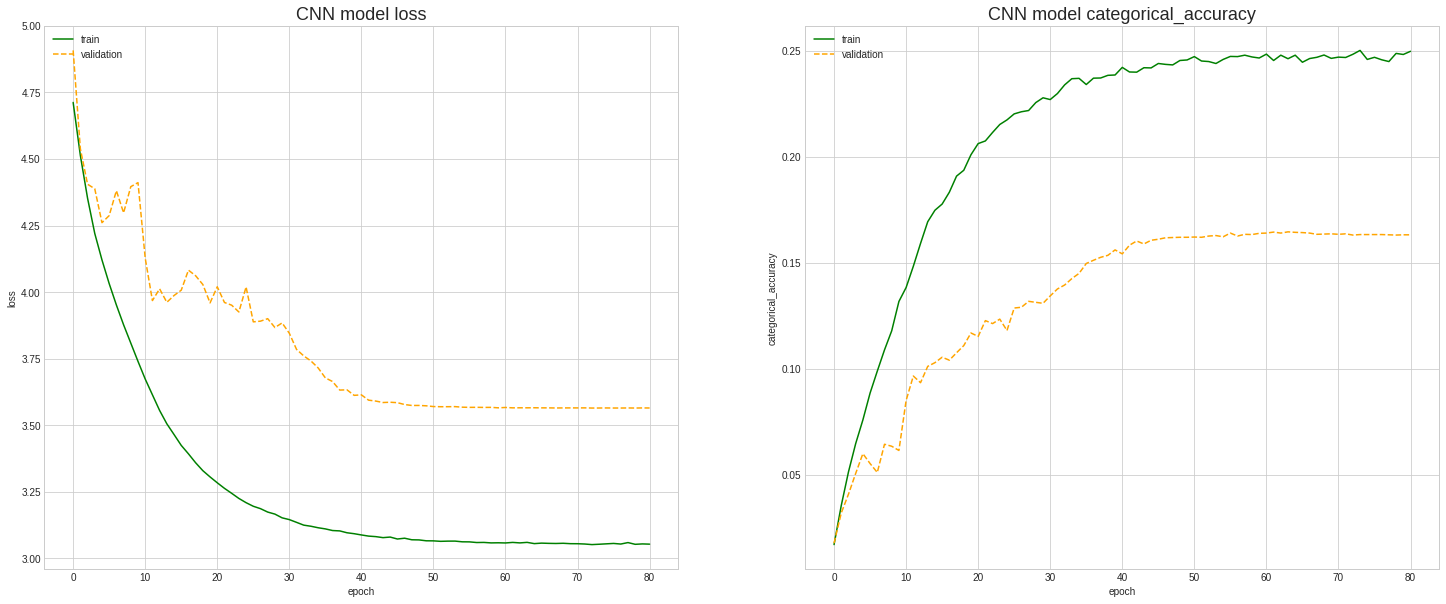

In [ ]:
compile_and_run(model_scratch, "model_scratch", 100)

Le modèle est bien meilleur, même si sa performance brute n'atteint pas des résultats satisfaisants:
* 25 % d'accuracy
* apprentissage s'arrette après 80 epochs

Cela étant, ce modèle apprend, contrairement aux précédents.

### Optimisation des hyper parametres

On utilise keras tuner

In [17]:
def build_model(hp):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(
        filters=hp.Int("filters", min_value=16, max_value=64, step=16),
        kernel_size=3,
        padding='same', 
        activation='relu'))
    model.add(layers.BatchNormalization(axis=3, scale=False))
    model.add(layers.Activation('relu'))

    # Pooling layer
    model.add(layers.MaxPooling2D(
        pool_size=(4,4),
        strides=(4,4),
        padding='same'))
    model.add(layers.Dropout(0.2))

    # Second convolution layer
    model.add(layers.Conv2D(
        filters=hp.Int("filters", min_value=16, max_value=64, step=16), 
        kernel_size=3, 
        padding='same', 
        activation='relu'))
    model.add(layers.BatchNormalization(axis=3, scale=False))
    
    if(hp.Boolean('activation')):
        model.add(layers.Activation('relu')) #new
    
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.2))

    # Third convolution layer
    model.add(layers.Conv2D(
        filters=hp.Int("filters", min_value=16, max_value=64, step=16),
        kernel_size=3, 
        padding='same', 
        activation='relu'))
    model.add(layers.BatchNormalization(axis=3, scale=False))
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(NO_BREEDS, activation='softmax'))

    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.CategoricalCrossentropy(),
      metrics=[keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )

    return model

In [18]:
# model = build_model(kt.HyperParameters())
# compile_and_run(model, 'cnn3_hp')

In [28]:
tuner = kt.RandomSearch(
    build_model,
    max_trials=10,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="loss",
    # Set a directory to store the intermediate results.
    directory="/tmp/tb",
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
activation (Boolean)
{'default': False, 'conditions': []}


In [19]:
# WARNING : this code use a lot of memory : approx 40Gb
#train_x_batches = np.concatenate([x for x, y in train_ds], axis=0)
#train_y_batches = np.concatenate([y for x, y in train_ds], axis=0)

In [ ]:
for images, labels in train_ds.take(3):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

numpy_images

In [29]:
# WARNING : this code use a lot of memory : approx 40Gb

tuner.search(
    np.concatenate([x for x, y in train_ds.take(3)], axis=0),
    np.concatenate([y for x, y in train_ds.take(3)], axis=0),
    validation_split=0.2,
    epochs=2,
    # Use the TensorBoard callback.
    # The logs will be write to "/tmp/tb_logs".
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)

Trial 6 Complete [00h 00m 11s]
loss: 4.615081310272217

Best loss So Far: 4.574191093444824
Total elapsed time: 00h 00m 46s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [30]:
tuner.results_summary()

Results summary
Results in /tmp/tb/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
filters: 64
activation: False
Score: 4.574191093444824
Trial summary
Hyperparameters:
filters: 64
activation: True
Score: 4.615081310272217
Trial summary
Hyperparameters:
filters: 32
activation: True
Score: 4.678829193115234
Trial summary
Hyperparameters:
filters: 48
activation: True
Score: 4.686814308166504
Trial summary
Hyperparameters:
filters: 32
activation: False
Score: 4.706744194030762
Trial summary
Hyperparameters:
filters: 16
activation: True
Score: 4.753072738647461


Query the results

In [34]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 64)     192       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 299, 299, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0

Retrain the model

In [35]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
# x_all = np.concatenate((x_train, x_val))
# y_all = np.concatenate((y_train, y_val))
# model.fit(x=x_all, y=y_all, epochs=1)

compile_and_run(model, "optimized_cnn-3")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 299, 299, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 299, 299, 64)     192       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 299, 299, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 75, 75, 64)       

KeyboardInterrupt: 

In [36]:
%load_ext tensorboard

%tensorboard --logdir /tmp/tb_logs

In [ ]:
model_scratch = Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#   layers.Resizing(IMG_SIZE, IMG_SIZE, crop_to_aspect_ratio=True),
  layers.Rescaling(1./255),
#   layers.Reshape((IMG_SIZE, IMG_SIZE, 3)),
  
  # Convolution layer
  layers.Conv2D(filters=16,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.Activation('relu'),

  # Pooling layer
  layers.MaxPooling2D(pool_size=(4,4),
                      strides=(4,4),
                    padding='same'),
  # Second convolution layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),   #add dropout for better performances

  # Third convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.GlobalAveragePooling2D(),
  
  # Fully connected layers
  layers.Dense(128, activation='relu'),
  layers.Dense(NO_BREEDS, activation='softmax')
])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 299, 299, 16)      448       
                                                                 
 batch_normalization_9 (Batc  (None, 299, 299, 16)     48        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 299, 299, 16)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 75, 32)       

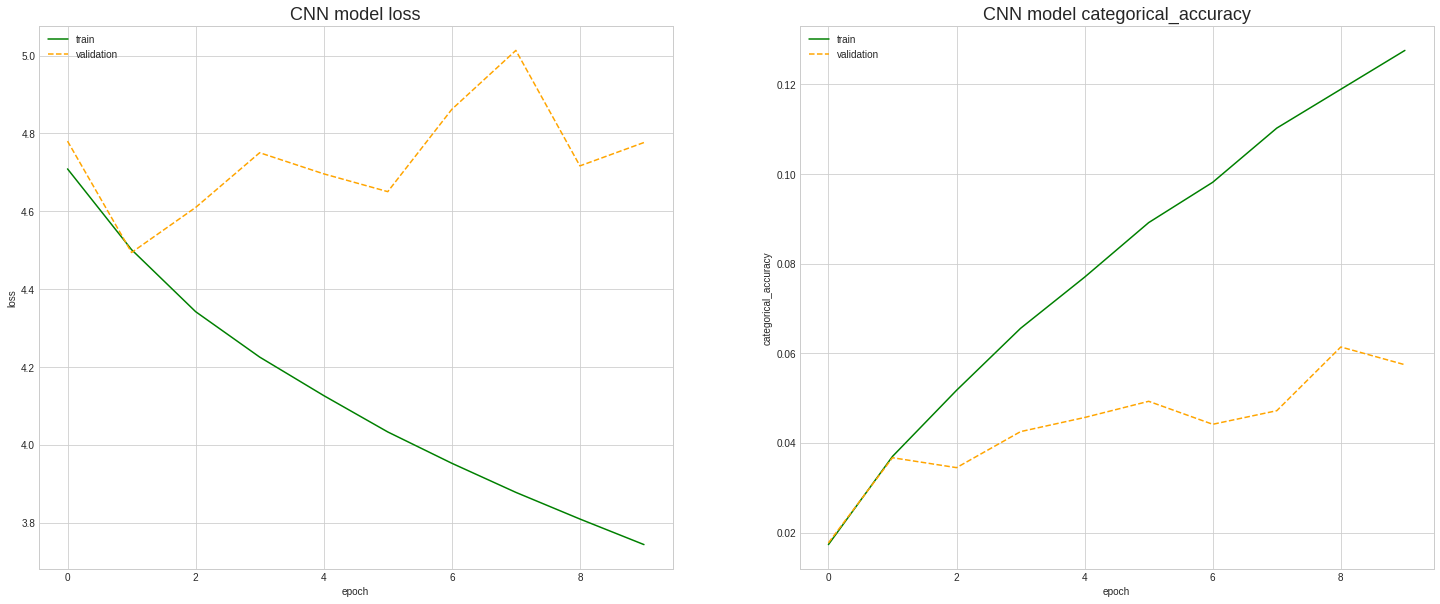

In [ ]:
compile_and_run(model_scratch, "model_scratch", 100)

On voit qu'après 600 epochs, qui représente + 3h de compute, accuracy continue de progresser. Mais on est clairement dans de l'overfitting, car le validation loss continue de progresser, alors que le training loss continue de baisse.

Par contre on risquerait de faire de l'over fitting. Pour éviter cela, en plus de la couche de dropout, et de la data augmentation, on peut ajouter de la regularisation.


explication tensorflow: <https://www.tensorflow.org/tutorials/keras/overfit_and_underfit>

explication underfitting / overfitting : <https://www.baeldung.com/cs/training-validation-loss-deep-learning>




In [ ]:
history_scratch.model.save('scratch_trained_model.h5')

## Xception model

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(NO_BREEDS, activation='softmax')(x)  #120 = number of breeds
model = keras.Model(inputs, outputs)

Train top layer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

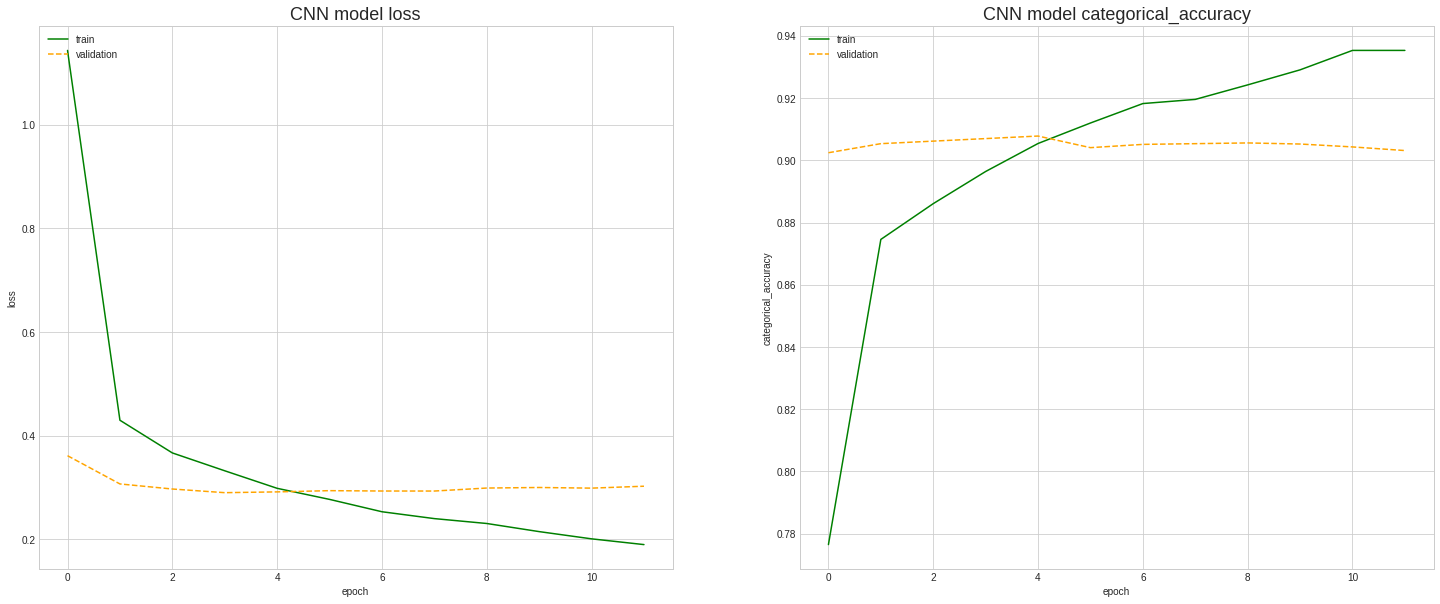

In [ ]:
compile_and_run(model, "xception_trained_model", epochs=25, save_model=True)

Estimation rapide

In [ ]:
for images, labels in test_ds.take(2):
    for i in range(labels.shape[0] -1):
        label_id = np.argmax(labels[i])
        label_name = ds_info.features['label'].names[label_id]
        found_label_id = np.argmax(model(images, training=False)[i], axis=0)
        found_label = ds_info.features['label'].names[found_label_id]
        if (label_id == found_label_id):
            found = 'ok !'
        else:
            found = ':('
        print(f'given: {label_name} --> found: {found_label} -- {found}')


given: n02102177-welsh_springer_spaniel --> found: n02102177-welsh_springer_spaniel -- ok !
given: n02106662-german_shepherd --> found: n02106662-german_shepherd -- ok !
given: n02099712-labrador_retriever --> found: n02099712-labrador_retriever -- ok !
given: n02088466-bloodhound --> found: n02088466-bloodhound -- ok !
given: n02107683-bernese_mountain_dog --> found: n02107683-bernese_mountain_dog -- ok !
given: n02093859-kerry_blue_terrier --> found: n02093859-kerry_blue_terrier -- ok !
given: n02099429-curly-coated_retriever --> found: n02099429-curly-coated_retriever -- ok !
given: n02088094-afghan_hound --> found: n02088094-afghan_hound -- ok !
given: n02102318-cocker_spaniel --> found: n02102318-cocker_spaniel -- ok !
given: n02110185-siberian_husky --> found: n02110185-siberian_husky -- ok !
given: n02088238-basset --> found: n02088238-basset -- ok !
given: n02085782-japanese_spaniel --> found: n02085782-japanese_spaniel -- ok !
given: n02100583-vizsla --> found: n02100583-vizsl

Certaines prédictions sont fausses, en regardant des exemples de races, on constate qu'elles sont très proches ce qui peut induire le modèle en erreur.

Le modèle a confondu ces races :

coated_wheaten_terrier avec sealyham_terrier : 
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/coated_wheaten_terrier.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/sealyham_terrier.jpg?raw=1)

airedale avec lakeland_terrier:
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/airedale.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/lakeland_terrier.jpg?raw=1)

standard_poodle avec miniature_poodle
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/standard_poodle.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/miniature_poodle.jpg?raw=1)

norwegian_elkhound avec leonberg
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/norwegian_elkhound.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/leonberg.jpg?raw=1)

Il pourrait être difficile pour quelqu'un de non avisé de faire la différence.

## APPENDIX & Docs

### Data augmentation:

<https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/>


### Model compile

What are the choices for optimizer, loss & metrics ? : <https://keras.io/guides/training_with_built_in_methods#many-builtin-optimizers-losses-and-metrics-are-available>

* optimizers: <https://keras.io/api/optimizers/>
* Losses: <https://keras.io/api/losses/>
* Metrics: <https://keras.io/api/metrics/>



tip: in order to view GPU usage, type command: `watch -n 1 nvidia-smi`

### Pre-trained model : Transfer Learning

Kera doc: <https://keras.io/guides/transfer_learning/>

deep learning with Python <https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html>

